In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [2]:
import sys
import os

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from tqdm import tqdm
import json

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import operator
import statsmodels.api as sm

utils.reset_seeds(0)
pd.set_option('display.max_columns', 50)

In [3]:
sns.set_context("paper")
sns.set_style('ticks')

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams["font.family"] = "Calibri"
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['savefig.dpi'] = 600

In [4]:
paths = ["andmed/all_four/const_order.csv", "andmed/all_four/const_reverse.csv", "andmed/all_four/sin_order.csv", "andmed/all_four/sin_reverse.csv"]
df_koik = pd.concat([utils.read_aggregated_data(path) for path in paths], axis=0)
df_koik.shape

(1896, 41)

In [5]:
regioon = ['a', 'b', 'c', 'd', 'e']
naabrid = [['b'], ['a','c'], ['b','d'], ['c','e'], ['d']]
kaugemad = [['c'], ['d'], ['a','e'], ['b'], ['c']]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))


In [6]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    # print(f'Dropping feature: {max_p_value}')
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value

def treeni_ols(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    kasutusel_featured = {col: 1 for col in X.columns}

    insignificant_feature = True
    X = sm.add_constant(X)
    
    while insignificant_feature:
        
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0

    # for k, v in kasutusel_featured.items():
    #     print(v, sep=";", end=";")

    # print(results.rsquared, sep=";", end=";")
    # print(results.mse_model, sep=";", end=";")
    # print(results.aic, sep=";", end=";")
    # print(results.bic, sep=";", end=";")
    # print(results.summary())
    return results, X, y

In [68]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      
        

suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)


# TODO üle käia ega need olemasolevad elemendid ei muutu
suurX["my_points_combo"] = suurX.my_points * -0.3762 + suurX.my_points_m1 * -3.3876 + suurX.my_points_log * 1.3885 + suurX.my_points_logm1 * 4.0044 + np.ones(shape=suurX.shape[0]) * -1.0568
suurX["neighbour_points_combo"] = suurX.neighbour_points * -0.3268 + suurX.neighbour_points_m1 * -1.7966 + suurX.neighbour_points_log * 0.7729 + suurX.neighbour_points_logm1 *1.7054 + np.ones(shape=suurX.shape[0]) * -0.5441
# suurX["distant_points_combo"] = suurX.distant_points * result3.params["distant_points"] + suurX.distant_points_m1 * result3.params["distant_points_m1"] + suurX.distant_points_log * result3.params["distant_points_log"] + suurX.distant_points_logm1 * result3.params["distant_points_logm1"] + np.ones(shape=suurX.shape[0]) * result3.params["const"]
suurX["points_combo"] = suurX.my_points_combo * 0.8223 + suurX.neighbour_points_combo * 0.2080# + const4 * result4.params["const"]

suurX["bpoints_combo"] = suurX.my_bpoints * -0.4097 + suurX.neighbour_bpoints * -0.1139 + suurX.distant_bpoints * -0.0604 + np.ones(shape=suurX.shape[0]) * 0.0618

# 'my_raw_mean2','neighbour_raw_mean2', 'distant_raw_mean2',
# 'mse_treeningul', 'points_combo', 'bpoints_combo'


suurX.drop(['my_bpoints', 'neighbour_bpoints', 'distant_bpoints', 
        'my_points','neighbour_points_combo', 'my_points_combo', 
       'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
       'my_points_logm1', 'neighbour_points_m1', 'neighbour_points_log',
       'neighbour_points_logm1', 'distant_points_m1', 'distant_points_log',
       'distant_points_logm1', ], axis=1, inplace=True)

uuritavad_col = suurX.columns
reg_scaler = MinMaxScaler()
suurX = reg_scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result7, newX, newy = treeni_ols(suurX, suury)
regressioon_mudel, newX, newy = treeni_ols(suurX, suury)


result7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.337
Model:                            OLS   Adj. R-squared (uncentered):              0.336
Method:                 Least Squares   F-statistic:                              814.4
Date:                Sat, 29 Apr 2023   Prob (F-statistic):                        0.00
Time:                        11:28:31   Log-Likelihood:                          956.03
No. Observations:                8030   AIC:                                     -1902.
Df Residuals:                    8025   BIC:                                     -1867.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
neighbour_raw_mean2     0.6394      0.031     20.876      0.000       0.579       0.699
distant_raw_mean2       0.6937      0.027     25.354      0.000       0.640       0.747
mse_treeningul         -0.3719      0.014    -26.235      0.000      -0.400      -0.344
points_combo           -0.5557      0.011    -50.437      0.000      -0.577      -0.534
bpoints_combo           0.3696      0.014     26.960      0.000       0.343       0.396
==============================================================================
Omnibus:                     2498.561   Durbin-Watson:                   0.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21406.246
Skew:                           1.246   Prob(JB):                         0.00
Kurtosis:                      10.601   Cond. No.                         18.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
def train_model(
    trainX: np.ndarray,
    nn_size: tuple[int, int] = (20, 20),
    optimizer: keras.optimizers = keras.optimizers.Adam(
        learning_rate=0.003, amsgrad=True, epsilon=1e-3),
    epochs: int = 1000,
    batch_size: int = None,
    fn=lambda x: 0*x,
    noise_fn=lambda x: 0.3 *
        np.random.randn(len(x)) + 0.3 * x * np.random.randn(len(x)),
    reverse_fn: bool = False,
    reverse_noise: bool = False,
    seed: int = None
) -> tuple[keras.Model, keras.callbacks.History, tuple[np.ndarray, np.ndarray]]:
    """Mudeli treenimine, voib kasutada erinevaid funktsioone ja mÃ¼ra, tagastab mudeli, ajaloo ja treeningandmed

    :param trainX: treeningX andmed
    :param nn_size: vorgu kihtide suurused, hetkel ainult 2 kihti lubatud, defaults to (20, 20)
    :param optimizer: optimiseerija, hetkel valitud hea vÃ¤iksematele andmehulkadele, defaults to keras.optimizers.Adam( learning_rate=0.003, amsgrad=True, epsilon=1e-3)
    :param epochs: epochide kogus, defaults to 1000
    :param batch_size: batch size, kasutab valemit min(16, kahe aste mis > len(X)/5), defaults to 16
    :param fn: funktsioon mida oppida, defaults to lambdax:0*x
    :param noise_fn: mÃ¼rafn, defaults to lambdax:0.3*np.random.randn(len(x))+0.3*x*np.random.randn(len(x))
    :param reverse_fn: kas pÃ¶Ã¶rata fn tagurpidi, defaults to False
    :param reverse_noise: kas pÃ¶Ã¶rata mÃ¼ra tagurpidi, defaults to False
    :param seed: seed, defaults to 42
    :return: treenitud mudel, ajalugu, treeningandmed
    """
    if seed:
        utils.reset_seeds(seed)

    model = keras.Sequential([
        layers.Input(shape=(1,)),
        layers.Dense(units=nn_size[0], activation='relu', name="layer_1"),
        layers.Dense(units=nn_size[1], activation='relu', name="layer_2"),
        layers.Dense(units=2, activation='linear', name="layer_3")
    ])

    X = trainX

    # koik voimalikud kombod reverse_fn ja reverse_noise. Default on tavalist pidi
    if reverse_fn and reverse_noise:
        y = fn(X[::-1]) + noise_fn(X[::-1])
    elif reverse_fn:
        y = fn(X[::-1]) + noise_fn(X)
    elif reverse_noise:
        y = fn(X) + noise_fn(X[::-1])
    else:
        y = fn(X) + noise_fn(X)

    X_train, y_train = X, y

    model.compile(
        optimizer=optimizer,
        loss=utils.neg_log_likelihood,
    )

    if batch_size is None:
        batch_size = min(16, max(2, 2**int(np.log2(len(trainX)/5+0.001)+1)))

    # TODO: validation_batch_size ja validation_freq saab kasutada et vaadata kuidas viga treeningu jooksul muutub
    h = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
                  callbacks=[CustomLogger(100)], shuffle=True, )
    return model, h, (X_train, y_train)


def fn(X):
    return X*np.sin(X)


def noise_fn(X):
    return 0.3 * np.random.randn(len(X)) + 0.3 * X * np.random.randn(len(X))

def create_x_train(train_size, different_place, different_multiplier=1, x_range=(0, 10), n_places=5, seed=None):
    # utils.reset_seeds(seed)

    keskmine_num = train_size/n_places  # A
    erinev_num = different_multiplier*keskmine_num  # B
    piirkond = (x_range[1]-x_range[0])/n_places
    piirkonnad = [(x_range[0]+i*piirkond, x_range[0]+(i+1)*piirkond)
                  for i in range(n_places)]
    #print(f"piirkond: {piirkond}")
    #print(f"piirkonnad: {piirkonnad}")

    X_train = []
    for idx, p in enumerate(piirkonnad):
        if idx == different_place:
            X_train.append(np.random.uniform(p[0], p[1], int(erinev_num)))
        else:
            X_train.append(np.random.uniform(p[0], p[1], int(keskmine_num)))

    X_train = np.concatenate(X_train)
    return X_train


X_train = create_x_train(70, different_place=0, different_multiplier=2.0, x_range=(0, 10), n_places=5, seed=0)
X_test = np.linspace(-2, 12, 10000)
nn_model, _h, (X_train, y_train) = train_model(
    X_train, nn_size=(20, 20), epochs=3000,
    # TODO important: kas algvaartustatakse alati sama seediga
    fn=fn, noise_fn=noise_fn, seed=0,
    reverse_noise=False,
)
diccy = {
    'train_size':70, 
    'random_seed':0,
    'multiplier':2.0,
    'region':'A',
}

Epoch:   0 | Loss: 2.17708e+01
Epoch: 100 | Loss: 2.86869e+00
Epoch: 200 | Loss: 2.17671e+00
Epoch: 300 | Loss: 2.11391e+00
Epoch: 400 | Loss: 2.09868e+00
Epoch: 500 | Loss: 2.06045e+00
Epoch: 600 | Loss: 2.09117e+00
Epoch: 700 | Loss: 2.01110e+00
Epoch: 800 | Loss: 1.96771e+00
Epoch: 900 | Loss: 1.94124e+00
Epoch: 1000 | Loss: 1.90565e+00
Epoch: 1100 | Loss: 1.86402e+00
Epoch: 1200 | Loss: 1.81390e+00
Epoch: 1300 | Loss: 1.76903e+00
Epoch: 1400 | Loss: 1.70265e+00
Epoch: 1500 | Loss: 1.56276e+00
Epoch: 1600 | Loss: 1.43784e+00
Epoch: 1700 | Loss: 1.37784e+00
Epoch: 1800 | Loss: 1.29824e+00
Epoch: 1900 | Loss: 1.21264e+00
Epoch: 2000 | Loss: 1.15955e+00
Epoch: 2100 | Loss: 1.10235e+00
Epoch: 2200 | Loss: 9.56692e-01
Epoch: 2300 | Loss: 9.11038e-01
Epoch: 2400 | Loss: 8.47480e-01
Epoch: 2500 | Loss: 7.57313e-01
Epoch: 2600 | Loss: 6.96263e-01
Epoch: 2700 | Loss: 7.25880e-01
Epoch: 2800 | Loss: 6.99121e-01
Epoch: 2900 | Loss: 7.49465e-01


model contains 19 breaks
1/1 [==============================] - 0s 30ms/step


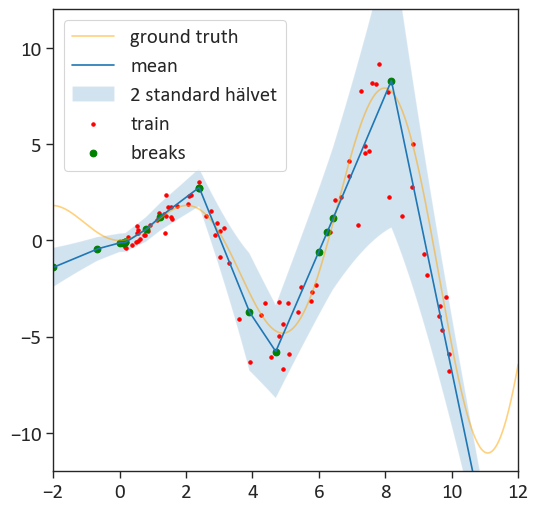

In [13]:
utils.joonista_variance(nn_model, X_test, X_train, y_train,ground_truth=lambda x:x*np.sin(x), ylim=(-12,12), xlim=(-2,12))

In [152]:
def create_df_for_regression(model, X_train, y_train, diccy, scaler):
    # diccy on 'train_size', 'random_seed', 'multiplier', 'region',
    df_columns = ['train_size', 'random_seed', 'multiplier', 'region',
              *[f'bpoints_in_{chr(a)}' for a in range(97, 97+5)],
              #*[f'ext_bpoints_in_{chr(a)}' for a in range(97, 97+5)],
              #*[f'abs_diff_in_{chr(a)}' for a in range(97, 97+5)],
              *[f'rel_diff_in_{chr(a)}' for a in range(97, 97+5)],
              *[f'raw_mean2_in_{chr(a)}' for a in range(97, 97+5)],
              #*[f'raw_mean3_in_{chr(a)}' for a in range(97, 97+5)],
              'mse_treeningul',]
    
    y_pred_train = model.predict(
                X_train, batch_size=65536, verbose=0)
    # y_pred_test = model.predict(np.linspace(0,10,10**5), batch_size=65536, verbose=0)
    
    rmses, rmse_fig = utils.joonista_rmses5x(model=model, start=0, end=10, steps=1000, akna_laius=0.1,
                                                     fn=fn, noise_fn=noise_fn, analyytiline_myra=lambda x: 0.09*x**2+0.09, reverse_noise=False, show_plt=False)
    plt.close()

    mse_treeningul = keras.losses.mean_squared_error(y_train, y_pred_train[:, 0])
    
    r_all = np.split(rmses, np.searchsorted(rmses[:, 0], v=np.arange(0,12,2)))[1:-1]
    absoluut_vahed = [np.mean(r[:, 2] - r[:, 3]) for r in r_all]
    r3_mean = [np.mean(r[:, 3]) for r in r_all]
    r2_mean =  [np.mean(r[:, 2]) for r in r_all]
    suhtelised_vahed = [absoluut / r_m for absoluut, r_m in zip(absoluut_vahed, r3_mean)]

    bpoints = Slopes.new_breakpoint_finder(model, np.linspace(-2, 12, 10**6))
    bpoints = np.asarray([bp[0] for bp in bpoints])
    bpoints_hist = np.histogram(bpoints[:, 0], bins=np.arange(0, 12, 2))[0]

    # print("andmed")
    # print([*diccy.values(), *bpoints_hist, *suhtelised_vahed, mse_treeningul])
    # print("nimed")
    # print(df_columns)
    # print(mse_treeningul.numpy())
    andmestik = pd.DataFrame(data=[[*diccy.values(), *bpoints_hist, *suhtelised_vahed, *r2_mean, mse_treeningul.numpy()]], columns=df_columns)
    # display(andmestik.head(5))
    Xid, yid = [], []
    for r, n, k in regioonide_combod:
        
        X, y = utils.transform_no_scaling(andmestik, r, n, k)
        # print(r)
        # display(X.head())
        Xid.append(X)
        yid.append(y)      


    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)



    # TODO üle käia ega need olemasolevad elemendid ei muutu
    suurX["my_points_combo"] = suurX.my_points * -0.3762 + suurX.my_points_m1 * -3.3876 + suurX.my_points_log * 1.3885 + suurX.my_points_logm1 * 4.0044 + np.ones(shape=suurX.shape[0]) * -1.0568
    suurX["neighbour_points_combo"] = suurX.neighbour_points * -0.3268 + suurX.neighbour_points_m1 * -1.7966 + suurX.neighbour_points_log * 0.7729 + suurX.neighbour_points_logm1 *1.7054 + np.ones(shape=suurX.shape[0]) * -0.5441
    # suurX["distant_points_combo"] = suurX.distant_points * result3.params["distant_points"] + suurX.distant_points_m1 * result3.params["distant_points_m1"] + suurX.distant_points_log * result3.params["distant_points_log"] + suurX.distant_points_logm1 * result3.params["distant_points_logm1"] + np.ones(shape=suurX.shape[0]) * result3.params["const"]
    suurX["points_combo"] = suurX.my_points_combo * 0.8223 + suurX.neighbour_points_combo * 0.2080# + const4 * result4.params["const"]

    suurX["bpoints_combo"] = suurX.my_bpoints * -0.4097 + suurX.neighbour_bpoints * -0.1139 + suurX.distant_bpoints * -0.0604 + np.ones(shape=suurX.shape[0]) * 0.0618

    # 'my_raw_mean2','neighbour_raw_mean2', 'distant_raw_mean2',
    # 'mse_treeningul', 'points_combo', 'bpoints_combo'


    suurX.drop(['my_bpoints', 'neighbour_bpoints', 'distant_bpoints', 
            'my_points','neighbour_points_combo', 'my_points_combo', 
        'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
        'my_points_logm1', 'neighbour_points_m1', 'neighbour_points_log',
        'neighbour_points_logm1', 'distant_points_m1', 'distant_points_log',
        'distant_points_logm1', ], axis=1, inplace=True)
    uuritavad_col = suurX.columns
    suurX = scaler.transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)
    suurX.drop(columns=['my_raw_mean2'], axis=1, inplace=True)
    return suurX
    

andmed  = create_df_for_regression(nn_model,X_train, y_train, diccy, reg_scaler)
andmed.head()

,neighbour_raw_mean2,distant_raw_mean2,mse_treeningul,points_combo,bpoints_combo
0,0.086439,0.182254,0.098891,0.988330,0.449376
1,0.085046,0.349703,0.098891,0.994574,0.693850
2,0.191720,0.185737,0.098891,0.995382,0.779901
3,0.227486,0.101777,0.098891,0.995382,0.808929
4,0.297000,0.182254,0.098891,0.995382,0.877736


In [153]:
def predict_corrected(relu_model:tf.keras.Sequential, reg_model, X_test, X_train, y_train, diccy, scaler ):
    preds = relu_model.predict(X_test, batch_size=32768, verbose=0)

    df_for_reg = create_df_for_regression(relu_model, X_train, y_train, diccy, scaler)
    correctors = reg_model.predict(df_for_reg)
    b = correctors.repeat(X_test.shape[0]/5)
    # print(type(correctors))
    # print(correctors)
    
    
    y_pred_mean = preds[:,0]
    y_pred_logvar = preds[:,1]
    a = y_pred_logvar
    y_pred_sd = np.sqrt(np.exp(y_pred_logvar))
    # print(y_pred_mean)
    # print(y_pred_logvar)

    x = a / (b+1) # ühik : logvar
    x_sd = np.sqrt(np.exp(x))

    # lols_test = np.linspace(0,10,10**6)
    # lols_mean = fn(lols_test) + noise_fn(lols_test)
    # plt.scatter(lols_test, lols_mean, label="mean")
    # plt.fill_between(X_test, y_pred_mean - 2*y_pred_sd,
    #                      y_pred_mean + 2*y_pred_sd, alpha=0.2, )
    # plt.fill_between(X_test, y_pred_mean - 2*x_sd,
    #                      y_pred_mean + 2*x_sd, alpha=0.2, color='green')
    # plt.scatter(X_train, y_train, marker='.', color="red", label="train")

    return y_pred_mean, x

y_pred_mean, y_pred_logvar_corrected = predict_corrected(nn_model, regressioon_mudel, np.linspace(0,10, 10**5), X_train, y_train, diccy, reg_scaler)

In [117]:
xikene = np.linspace(0,10, 10**5)
y_true = fn(xikene) + noise_fn(xikene)
y_true.shape

(100000,)

In [124]:
y_parispred = nn_model.predict(xikene, batch_size=2**15, verbose=0)
y_parispred[:3]

array([[-0.12088418, -2.8428771 ],
       [-0.1208756 , -2.842864  ],
       [-0.12086654, -2.8428516 ]], dtype=float32)

In [125]:
asi = np.asarray([y_pred_mean, y_pred_logvar_corrected]).T
asi.shape
asi[:3]

array([[-0.12088418, -3.73204552],
       [-0.1208756 , -3.7320283 ],
       [-0.12086654, -3.73201203]])

In [129]:
def laisk_nll(y_true, ypredmean, ypredlogvar):
    # tf.reduce_mean(y_pred_var + tf.math.square(y_true - y_pred_mean) / tf.math.exp(y_pred_var))
    return np.mean(ypredmean + (y_true -ypredmean)**2 / np.exp(ypredlogvar))
print(laisk_nll(y_true, y_parispred[:,0], y_parispred[:,1]))
print(laisk_nll(y_true, y_pred_mean, y_pred_logvar_corrected))

2.2453305863326993
2.6106747911467543


In [133]:
X = np.linspace(0,10,1000000)
for file in os.listdir("andmed/testime_oma_meetodit/"):
    print(file)
    with open(os.path.join("andmed/testime_oma_meetodit/", file), 'rb') as f:
        data = np.load(f)
    print(data.shape)
    if 'const' in file:
        f = lambda X: 0*X
    else:
        f= lambda X:X*np.sin(X)
    if 'order' in file:
        y = fn(X) + noise_fn(X)
    else:
        y = fn(X) + noise_fn(X[::-1])
    
    

const_order_40_3_0.25_D.npy
(1000000, 2)
const_order_60_14_1.0_E.npy
(1000000, 2)
sin_reverse_100_8_0.5_A.npy
(1000000, 2)
sin_reverse_175_19_2.0_C.npy
(1000000, 2)


In [158]:
def train_and_evaluate(params):
    train_size = params['train_size']
    random_seed = params['random_seed']
    multiplier = params['multiplier']
    region = ord(params['region'])-65
    fn = params['fn']
    noise_fn=params["noise_fn"]
    reverse_noise = params["reverse_noise"]

    X_train = create_x_train(train_size, different_place=region, different_multiplier=multiplier, x_range=(
        0, 10), n_places=5, seed=random_seed)
    X_test = np.linspace(0, 10, 10000)

    y_true = fn(X_test) + noise_fn(X_test)
    if reverse_noise:
        y_true = fn(X_test) + noise_fn(X_test[::-1])

    nn_model, _h, (X_train, y_train) = train_model(
        X_train, nn_size=(20, 20), epochs=3000,
        # TODO important: kas algvaartustatakse alati sama seediga
        fn=fn, noise_fn=noise_fn, seed=0,
        reverse_noise=reverse_noise,
    )
    diccy = {
        'train_size': params['train_size'],
        'random_seed': params['random_seed'],
        'multiplier': params['multiplier'],
        'region': params['region'],
    }
    # andmed = create_df_for_regression(nn_model, X_train, diccy, reg_scaler)
    # andmed.head()
    y_preds = nn_model.predict(X_test, batch_size=2*15, verbose=0)
    y_pred_mean, y_pred_logvar_corrected = predict_corrected(
        nn_model, regressioon_mudel, X_test, X_train, y_train, diccy, reg_scaler)

    print("params", diccy)
    print("vana nll", laisk_nll(y_true, y_preds[:,0], y_preds[:,1]))
    print("uus nll ", laisk_nll(y_true, y_pred_mean, y_pred_logvar_corrected))


In [159]:
parameetrid = [
    {'train_size' : 200,
    'random_seed' : 0,
    'multiplier' : 2,
    'region' : 'B',
    'fn' : lambda X:0*X,
    'noise_fn':lambda X: 0.3 * np.random.randn(len(X)) + 0.3 * X * np.random.randn(len(X)),
    'reverse_noise' : False},
    {'train_size' : 100,
    'random_seed' : 0,
    'multiplier' : 0.5,
    'region' : 'E',
    'fn' : lambda X:0*X,
    'noise_fn':lambda X: 0.3 * np.random.randn(len(X)) + 0.3 * X * np.random.randn(len(X)),
    'reverse_noise' : False},
    {'train_size' : 250,
    'random_seed' : 0,
    'multiplier' : 0.25,
    'region' : 'A',
    'fn' : lambda X:X*np.sin(X),
    'noise_fn':lambda X: 0.3 * np.random.randn(len(X)) + 0.3 * X * np.random.randn(len(X)),
    'reverse_noise' : False},
    {'train_size' : 75,
    'random_seed' : 0,
    'multiplier' : 1,
    'region' : 'C',
    'fn' : lambda X:X*np.sin(X),
    'noise_fn':lambda X: 0.3 * np.random.randn(len(X)) + 0.3 * X * np.random.randn(len(X)),
    'reverse_noise' : True},
]

In [160]:
for par in parameetrid:
    train_and_evaluate(par)

Epoch:   0 | Loss: 5.71131e+00
Epoch: 100 | Loss: 1.32475e+00
Epoch: 200 | Loss: 1.32310e+00
Epoch: 300 | Loss: 1.31699e+00
Epoch: 400 | Loss: 1.32326e+00
Epoch: 500 | Loss: 1.31434e+00
Epoch: 600 | Loss: 1.30584e+00
Epoch: 700 | Loss: 1.31052e+00
Epoch: 800 | Loss: 1.30273e+00
Epoch: 900 | Loss: 1.30961e+00
Epoch: 1000 | Loss: 1.30383e+00
Epoch: 1100 | Loss: 1.30422e+00
Epoch: 1200 | Loss: 1.30031e+00
Epoch: 1300 | Loss: 1.29442e+00
Epoch: 1400 | Loss: 1.30226e+00
Epoch: 1500 | Loss: 1.29565e+00
Epoch: 1600 | Loss: 1.30602e+00
Epoch: 1700 | Loss: 1.29449e+00
Epoch: 1800 | Loss: 1.29953e+00
Epoch: 1900 | Loss: 1.29192e+00
Epoch: 2000 | Loss: 1.29852e+00
Epoch: 2100 | Loss: 1.29806e+00
Epoch: 2200 | Loss: 1.30645e+00
Epoch: 2300 | Loss: 1.29154e+00
Epoch: 2400 | Loss: 1.28736e+00
Epoch: 2500 | Loss: 1.29374e+00
Epoch: 2600 | Loss: 1.29131e+00
Epoch: 2700 | Loss: 1.29181e+00
Epoch: 2800 | Loss: 1.28712e+00
Epoch: 2900 | Loss: 1.29065e+00
params {'train_size': 200, 'random_seed': 0, 'mult

In [ ]:
def joonista_variance_corrected(m: tf.keras.Sequential, X_test, X_train, y_train=None, bpoint_fn=Slopes.breakpoint_finder, *, ground_truth=False, xlim=None, ylim=None, return_fig=False, no_variance=False, n_variances=2, title_text="", korrigeeritud_vars=None):

    bpoints = bpoint_fn(m, X_test)

    _patterns = [bp[1] for bp in bpoints]
    bpoints = [bp[0] for bp in bpoints]

    start, end = xlim if xlim else (-1, 1)

    print(f"model contains {len(bpoints)} breaks")

    y_pred = m.predict(X_test, batch_size=32768)

    if no_variance:
        y_pred_mean = y_pred
    else:
        y_pred_mean, y_pred_logvar = y_pred[:, 0], y_pred[:, 1]
        y_pred_var = np.exp(y_pred_logvar)
        
        if korrigeeritud_vars:
            a,b,c,d,e = korrigeeritud_vars
            y_pred_var[(0<=X_test) & (X_test<2)] = a #y_pred_sd[(0<=X_test) & (X_test<2)]
            y_pred_var[(2<=X_test) & (X_test<4)] = b #y_pred_sd[(2<=X_test) & (X_test<4)]
            y_pred_var[(4<=X_test) & (X_test<6)] = c #y_pred_sd[(4<=X_test) & (X_test<6)]
            y_pred_var[(6<=X_test) & (X_test<8)] = d #y_pred_sd[(6<=X_test) & (X_test<8)]
            y_pred_var[(8<=X_test) & (X_test<10)] = e #y_pred_sd[(8<=X_test) & (X_test<10)]
        
        y_pred_sd = np.sqrt(y_pred_var)



    fig, ax = plt.subplots(figsize=(6, 6))
    plt.xlim(xlim)
    plt.ylim(ylim)

    # absoluutselt õige
    if ground_truth:
        plt.plot(np.linspace(start, end, 1000), ground_truth(np.linspace(
            start, end, 1000)), label="ground truth", alpha=0.5, color="orange")

    plt.plot(X_test, y_pred_mean, label="mean")
    if not no_variance:
        plt.fill_between(X_test, y_pred_mean - n_variances*y_pred_sd,
                         y_pred_mean + n_variances*y_pred_sd, alpha=0.2, label=f"{n_variances} standard hälvet")
    plt.scatter(X_train, y_train, marker='.', color="red", label="train")

    temp_bpoints = list(zip(*bpoints))
    bx, by = temp_bpoints[0], temp_bpoints[1]

    plt.scatter(bx, by, marker="o", color="green", label="breaks")
    plt.title(title_text)
    plt.legend()

    if return_fig:
        return fig

    plt.show()

joonista_variance_corrected(model, X_test, X_train, y_train,ground_truth=lambda x:x*0, ylim=(-10,10), xlim=(-2,12), korrigeeritud_vars=[var_a, var_b, var_c, var_d, var_e])